In [181]:
module RealRobotWorld

    using Plots
    using Distributions

    include("../scripts/ideal_robot.jl")
    using .RobotWorld: Agent, Landmark, Map, IdealCamera, Robot, World
    using .RobotWorld: data, decision, state_transition, circle_shape, draw

    mutable struct RealRobot <: Robot
        pose::Array{Float64}
        color::Symbol
        r::Float64
        agent::Agent
        sensor::IdealCamera
        poses::Array{Array{Float64}}
        noise_per_meter::Float64
        noise_std::Float64
        bias_rate_stds::Array{Float64}
        expected_stuck_time::Float64
        expected_escape_time::Float64
        noise_pdf::Exponential{Float64}
        distance_until_noise::Float64
        theta_noise::Normal{Float64}
        bias_rate_nu::Float64
        bias_rate_omega::Float64
        stuck_pdf::Exponential{Float64}
        escape_pdf::Exponential{Float64}
        time_until_stuck::Float64
        time_until_escape::Float64
        is_stuck::Bool

        RealRobot(
            pose, color, r, agent, sensor=IdealCamera(Map()), poses=[pose],
            noise_per_meter=5, noise_std=pi/60.0, bias_rate_stds=[0.1, 0.1], expected_stuck_time=1e100, expected_escape_time=1e-100,
            noise_pdf=Exponential(1/(1e-100 + noise_per_meter)), 
            distance_until_noise=rand(noise_pdf), theta_noise=Normal(0, noise_std),
            bias_rate_nu = rand(Normal(1.0, bias_rate_stds[1])),
            bias_rate_omega = rand(Normal(1.0, bias_rate_stds[2])),
            stuck_pdf=Exponential(expected_stuck_time), 
            escape_pdf=Exponential(expected_escape_time),
            time_until_stuck=rand(stuck_pdf), time_until_escape=rand(escape_pdf),
            is_stuck=false    
        ) = new(
            pose, color, r, agent, sensor, poses, 
            noise_per_meter, noise_std, bias_rate_stds, expected_stuck_time, expected_escape_time,
            noise_pdf, 
            distance_until_noise, theta_noise,
            bias_rate_nu,
            bias_rate_omega,
            stuck_pdf,
            escape_pdf,
            time_until_stuck, time_until_escape,
            is_stuck
        )
    end

    function init(self::RealRobot, noise_per_meter, noise_std, bias_rate_stds, expected_stuck_time, expected_escape_time)    
        self.noise_per_meter = noise_per_meter
        self.noise_std = noise_std
        self.bias_rate_stds = bias_rate_stds
        self.expected_stuck_time = expected_stuck_time
        self.expected_escape_time = expected_escape_time

        self.noise_pdf=Exponential(1/(1e-100 + self.noise_per_meter)) 
        self.distance_until_noise=rand(self.noise_pdf)
        self.theta_noise=Normal(0, self.noise_std)
        self.bias_rate_nu = rand(Normal(1.0, self.bias_rate_stds[1]))
        self.bias_rate_omega = rand(Normal(1.0, self.bias_rate_stds[2]))
        self.stuck_pdf=Exponential(self.expected_stuck_time)
        self.escape_pdf=Exponential(self.expected_escape_time)
        self.time_until_stuck=rand(self.stuck_pdf)
        self.time_until_escape=rand(self.escape_pdf)
        self.is_stuck=false    
    
        return self
    end

    function append(self::World, obj::RealRobot)
        push!(self.objects, deepcopy(obj))
    end

    function noise(self::RealRobot, pose, nu, omega, time_interval)
    
       self.distance_until_noise = self.distance_until_noise - abs(nu) * time_interval + self.r * abs(omega) * time_interval
        if self.distance_until_noise <= 0.0
            self.distance_until_noise = self.distance_until_noise + rand(self.noise_pdf)
            pose[3] = pose[3] + rand(self.theta_noise)
        end
        return pose
    end

    function bias(self::RealRobot, nu, omega)
        return nu*self.bias_rate_nu, omega*self.bias_rate_omega
    end

    function stuck(self::RealRobot, nu, omega, time_interval)
        if self.is_stuck
            self.time_until_escape = self.time_until_escape - time_interval
            if self.time_until_escape <= 0.0
                self.time_until_escape = self.time_until_escape = rand(self.escape_pdf)
                self.is_stuck = false
            end
        else
            self.time_until_stuck = self.time_until_stuck - time_interval
            if self.time_until_stuck <= 0.0
                self.time_until_stuck = self.time_until_stuck = rand(self.stuck_pdf)
                self.is_stuck = true
            end        
        end
        return nu*(!self.is_stuck), omega*(!self.is_stuck)
    end

    function RobotWorld.one_step(self::RealRobot, time_interval)
        obs = data(self.sensor, self.pose)
        nu, omega = decision(self.agent, obs)
        nu, omega = bias(self, nu, omega)
        nu, omega = stuck(self, nu, omega, time_interval)
        self.pose = state_transition(nu, omega, time_interval, self.pose)
        self.pose = noise(self, self.pose, nu, omega, time_interval)
    end

end

Main.RealRobotWorld

┌ Info: Saved animation to 
│   fn = /home/szmlb/workspace/github/code-practice/julia/detailed_probo/src/section_uncertainty/tmp.gif
└ @ Plots /home/szmlb/.julia/packages/Plots/FI0vT/src/animation.jl:114


Plots.AnimatedGif("/home/szmlb/workspace/github/code-practice/julia/detailed_probo/src/section_uncertainty/tmp.gif")
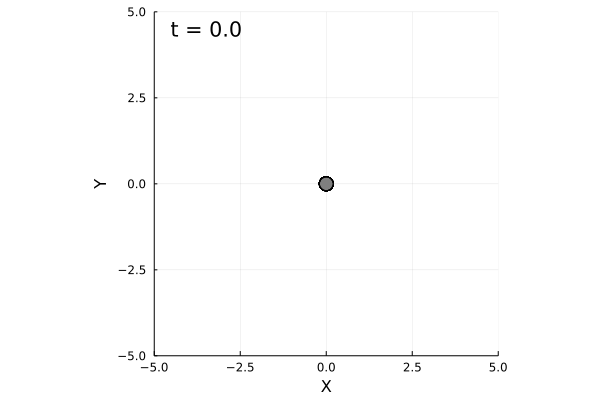

In [190]:
using .RealRobotWorld

world = RealRobotWorld.World(30, 0.1)

for i in 1:100
    circling = RealRobotWorld.Agent(0.2, 10.0/180*pi)
    r = RealRobotWorld.RealRobot([0, 0, 0], :gray, 0.2, circling)
    RealRobotWorld.init(r, r.noise_per_meter, r.noise_std, [0.0, 0.0], r.expected_stuck_time, r.expected_escape_time)
    
    RealRobotWorld.append(world, r)
end

RealRobotWorld.RobotWorld.draw(world)

┌ Info: Saved animation to 
│   fn = /home/szmlb/workspace/github/code-practice/julia/detailed_probo/src/section_uncertainty/tmp.gif
└ @ Plots /home/szmlb/.julia/packages/Plots/FI0vT/src/animation.jl:114


Plots.AnimatedGif("/home/szmlb/workspace/github/code-practice/julia/detailed_probo/src/section_uncertainty/tmp.gif")
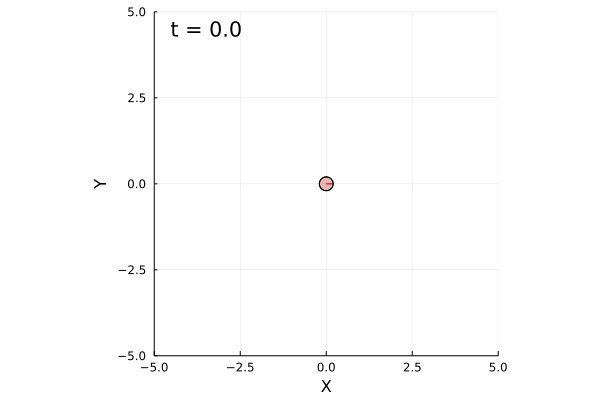

In [189]:
world = RealRobotWorld.World(30, 0.1)

circling = RealRobotWorld.Agent(0.2, 10.0/180*pi)
nobias_robot = RealRobotWorld.RealRobot([0, 0, 0], :gray, 0.2, circling)
RealRobotWorld.append(world, nobias_robot)

biased_robot = RealRobotWorld.RealRobot([0, 0, 0], :red, 0.2, circling)
RealRobotWorld.init(biased_robot, 0, biased_robot.noise_std, [0.2, 0.2], biased_robot.expected_stuck_time, biased_robot.expected_escape_time)
RealRobotWorld.append(world, biased_robot)

RealRobotWorld.RobotWorld.draw(world)

┌ Info: Saved animation to 
│   fn = /home/szmlb/workspace/github/code-practice/julia/detailed_probo/src/section_uncertainty/tmp.gif
└ @ Plots /home/szmlb/.julia/packages/Plots/FI0vT/src/animation.jl:114


Plots.AnimatedGif("/home/szmlb/workspace/github/code-practice/julia/detailed_probo/src/section_uncertainty/tmp.gif")
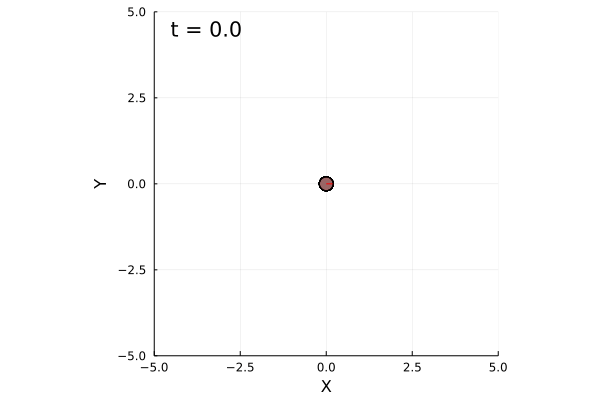

In [186]:
world = RealRobotWorld.World(30, 0.1)

for i in 1:100
    circling = RealRobotWorld.Agent(0.2, 10.0/180*pi)
    r = RealRobotWorld.RealRobot([0, 0, 0], :gray, 0.2, circling)
    RealRobotWorld.init(r, 0, 0.0, [0.0, 0.0], 60.0, 60.0)    
    
    RealRobotWorld.append(world, r)
end
r = RealRobotWorld.RobotWorld.IdealRobot([0, 0, 0], :red, 0.2, circling)    
RealRobotWorld.RobotWorld.append(world, r)

RealRobotWorld.RobotWorld.draw(world)